# Рекомендация тарифов

Цель: предсказать по признакам объекта (архивные данные клиентов телекоммуникационной компании), перейдет ли клиент на новую тарифную линейку. Метрика качества модели: accuracy.

**Описание данных**  
Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. 
is_ultra — целевой признак (1 - тариф "1" или 0 - другой тариф, всего тарифов 2)

In [24]:
import pandas as pd
import warnings
from scipy import stats as st
import math 
import seaborn as sns
import matplotlib as plt

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from sklearn.metrics import mean_squared_error


warnings.filterwarnings('ignore')

In [25]:
df = pd.read_csv('/Users/alexey_zalesov/Desktop/ya_prakrikum/ds/datasets/users_behavior.csv')

print(df.info())
display(df.head(20))
print(df.describe())





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB
None


,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


             calls      minutes     messages       mb_used     is_ultra
count  3214.000000  3214.000000  3214.000000   3214.000000  3214.000000
mean     63.038892   438.208787    38.281269  17207.673836     0.306472
std      33.236368   234.569872    36.148326   7570.968246     0.461100
min       0.000000     0.000000     0.000000      0.000000     0.000000
25%      40.000000   274.575000     9.000000  12491.902500     0.000000
50%      62.000000   430.600000    30.000000  16943.235000     0.000000
75%      82.000000   571.927500    57.000000  21424.700000     1.000000
max     244.000000  1632.060000   224.000000  49745.730000     1.000000


### Попробуем найти зависимость между столбцами для упрощения модели

In [26]:
df.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


<AxesSubplot:xlabel='messages', ylabel='mb_used'>

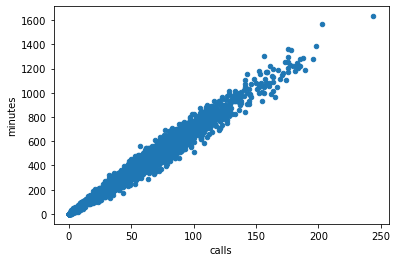

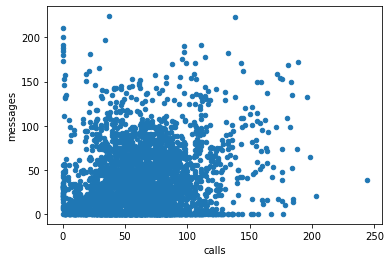

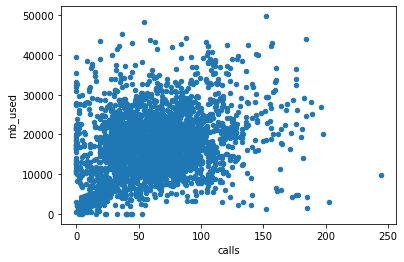

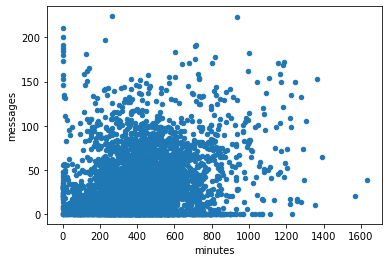

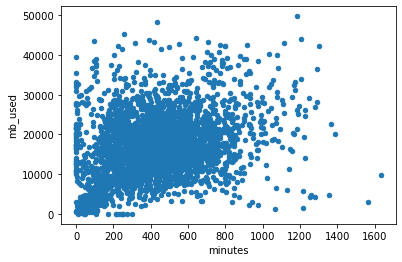

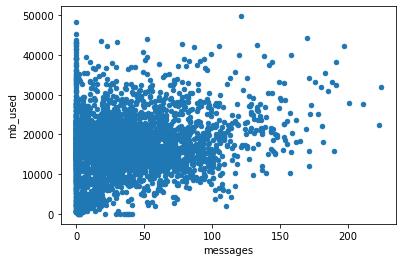

In [27]:
df.plot(x='calls', y='minutes', kind='scatter')
df.plot(x='calls', y='messages', kind='scatter')
df.plot(x='calls', y='mb_used', kind='scatter')

df.plot(x='minutes', y='messages', kind='scatter')
df.plot(x='minutes', y='mb_used', kind='scatter')

df.plot(x='messages', y='mb_used', kind='scatter')

Предлагаю исключить столбец "calls" из рассмотрения, так как у него корреляция со столбцом "minutes" = 0.982

## Разбейте данные на выборки

Предлагаю разбить выборки на тренировчную, валидационную и тестовую в соотношении 3:1:1, получится примерно 1900 объектов в тренировочной и примерно по 600 в валидационной и тестовой.

Сначала разобьем на тренировочную+валидационную и тестовую:

In [28]:
features = df.drop(columns=['is_ultra', 'calls'], axis=1)
target = df['is_ultra']



features_train_valid, features_test, target_train_valid, target_test = train_test_split(features, target,
                                                                                        test_size=0.2,
                                                                                        random_state=12345)

print(features_train_valid.shape)
print(features_test.shape)
print(target_train_valid.shape)
print(target_test.shape)


#все работает

(2571, 3)
(643, 3)
(2571,)
(643,)


Теперь разобьем тренировочную+валидационную на, собственно, тренировочную и валидационную:

In [29]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features_train_valid, target_train_valid, test_size=0.25, random_state=12345 )


print(features_train.shape)
print(features_valid.shape)
print(target_train.shape)
print(target_valid.shape)

#ура, все работает

(1928, 3)
(643, 3)
(1928,)
(643,)


## Исследуем модели

Предлагаю сравнить качество работы моделей: Случайный лес, Дерево решений, Логистическая регрессия. 

У какой модели будет лучший показатель accuracy, ту и булем использовать, как основную. 

В этой ячейку инициализируем модели, обучим, проверим на валидационной выборке.

In [30]:
#инициализируем модели
model_decision_tree = DecisionTreeClassifier(random_state=12345)
model_random_forest = RandomForestClassifier(random_state=12345, n_estimators=10, )
model_logistical_regression = LogisticRegression(random_state=12345)


#обучаем модели
model_decision_tree.fit(features_train, target_train)
model_random_forest.fit(features_train, target_train)
model_logistical_regression.fit(features_train, target_train)

#делаем предсказания на валидационной выборке
predictions_decision_tree = model_decision_tree.predict(features_valid) 
predictions_random_forest = model_random_forest.predict(features_valid) 
predictions_logistical_regression = model_logistical_regression.predict(features_valid) 

##проверяем предсказания на валидационной выборке по метрике accuracy
accuracy_score_decision_tree = accuracy_score(target_valid, predictions_decision_tree)
accuracy_score_random_forest = accuracy_score(target_valid, predictions_random_forest)
accuracy_score_logistical_regression = accuracy_score(target_valid, predictions_logistical_regression)


print("Качество модели дерева решений ", accuracy_score_decision_tree)
print("Качество модели случайного леса ", accuracy_score_random_forest)
print("Качество модели логистической регрессии ", accuracy_score_logistical_regression)








Качество модели дерева решений  0.6982892690513219
Качество модели случайного леса  0.7869362363919129
Качество модели логистической регрессии  0.7262830482115086


Лучшее качество показала модель случайного леса. Возьмем ее и попробуем ее еще улучшить, меняя гиперпараметры. Выберем лучшие параметры, которые будем в дальнейшем проверять на тестовой выборке. 

In [31]:
best_model = None
best_result = 0
best_depth = 0
best_est = 0
best_leaf_count = 0

for depth in range (5,15):
    for est in range (3, 30):
        for leaf in range (1,4):
        
            model = RandomForestClassifier(random_state=12345, max_depth = depth, n_estimators=est,
                                           min_samples_leaf = leaf )
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            
            accuracy = accuracy_score(target_valid, predictions)
            if accuracy>best_result:
                best_result = accuracy
                best_model = model
                best_depth = depth
                best_est = est
                best_leaf_count = 0
            

print('accuracy лучшей версии модели:', best_result)
print('Нужная глубина:', best_depth)
print('Нужное количество деревьев:', best_est)




accuracy лучшей версии модели: 0.8055987558320373
Нужная глубина: 10
Нужное количество деревьев: 20


accuracy лучшей версии модели: 0.80248833592535
Нужная глубина: 13
Нужное количество деревьев: 26
Нужное количество объектов для одного листка: 0

Запомнили нужные гиперпараметры, переходим к тестовой выборке, проверим, насколько хорошо справится модель с такими параметрами с ней

## Проверяем модель на тестовой выборке

In [32]:
test_predictions = best_model.predict(features_test)

test_accuracy = accuracy_score(target_test, test_predictions)
print('accuracy на тестовой выборке:', test_accuracy)


accuracy на тестовой выборке: 0.7884914463452566


Accuracy 0.79, подходит под наши условия. 

## Проверка модели на адекватность

Я считаю, для проверки стоит взять массив случайных дробных чисел от 0 до 1 такой же длины как и массив target_test, применить функцию ceiling для конвертации каждого полученного в 0 или 1 в зависимости от константы, которая также будет определена случайным образом в  диапазоне [0.4,0.6] , и посчитать значение метрики accuracy для такого "угадывания" этой "случайной" модели. 

In [33]:
import numpy as np
sanity_sample = np.random.random_sample(len(target_test))
sanity_const = np.random.random_integers(low=4, high=6)/10
def random_sanity(sample, const):
    for i in range(len(sample)):
        if sample[i] <= const:
            sample[i]=0
        else:
            sample[i]=1
    return sample

sample_after_random_ceiling = random_sanity(sanity_sample, sanity_const).astype('int')
display(sample_after_random_ceiling[:10])

accuracy_sanity_check = accuracy_score(target_test, sample_after_random_ceiling)
print('accuracy случайного массивыа той же длины:', accuracy_sanity_check)


array([0, 0, 1, 1, 1, 0, 1, 1, 1, 1])

accuracy случайного массивыа той же длины: 0.4432348367029549


Аccuracy случайного массива той же длины: 0.5396578538102644

Accuracy получилось больше половины (на этой итераци, у меня). Наверное, это позволяет утверждать, что наш случайный лес все же лучше, чем случайная величина. 

# Вывод

Данные были загружены и изучены. Далее они были разбиты на 3 выборки в соотношении 3:1:1 в два этапа. Было рассмотрено 3 модели для классификации, выбрана модлеь, показавшая лучший результат на валидационной выборке, после этого были проверены различные гиперпараметры для лучшей работы модели. На тестовой выборке итоговая модель показала accuracy 0.79. 
Также была попытка проверки на адекватность, которую модель, если такое можно считать проверкой, успешно прошла. 